<a href="https://colab.research.google.com/github/AnkitPatel745/Retail-Sales-Prediction-Capstone_Project/blob/main/Rossmann_Sales_Prediction_Capstone_Project(ML_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

##**Importing Libraries**

In [116]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import pylab
from numpy import math
from scipy  import stats as ss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Importing Warnings To Ignore the Warning
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [48]:
# Importing the dataset
df_Rstore = pd.read_csv("/content/drive/MyDrive/Datasets/Rossmann Stores Data.csv")
df_store = pd.read_csv("/content/drive/MyDrive/Datasets/store.csv")

In [49]:
# First Look
df_Rstore.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [50]:
# checking columns Names
df_Rstore.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [62]:
# Data Summary
df_Rstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [51]:
# Checking Size Of Data Set
df_Rstore.shape

(1017209, 9)

In [63]:
# checking the length of the column
len(df_Rstore)

1017209

In [76]:
# checking the Unique Values of columns
list1 = ["Promo", "Open", "DayOfWeek" , "StateHoliday" , "SchoolHoliday"]

for i in list1:
  print(i)
  print(df_Rstore[i].unique())
  print("-----------------------")

Promo
[1 0]
-----------------------
Open
[1 0]
-----------------------
DayOfWeek
[5 4 3 2 1 7 6]
-----------------------
StateHoliday
['0' 'a' 'b' 'c' 0]
-----------------------
SchoolHoliday
[1 0]
-----------------------


In [78]:
# Checking number of count of the columns
df_Rstore_column = list1
df_Rstore_counts = pd.DataFrame(df_Rstore[df_Rstore_column].melt(var_name='column', value_name='value').value_counts())\
.rename(columns={0: 'counts'}).sort_values(by=['column', 'counts'])
df_Rstore_counts

counts
column        value        
DayOfWeek     6      144730
              1      144730
              7      144730
              2      145664
              3      145665
              4      145845
              5      145845
Open          0      172817
              1      844392
Promo         1      388080
              0      629129
SchoolHoliday 1      181721
              0      835488
StateHoliday  c        4100
              b        6690
              a       20260
              0      131072
              0      855087


**a = public holiday, b = Easter holiday, c = Christmas, 0 = None**

Indicates if the (Store, Date) was affected by the closure of public schools

In [61]:
# Checking out the Time Peroid Of The Dataset 
print('Minimum date in given dataset is = ',df_Rstore['Date'].min())
print('Maximum date in given dataset is = ',df_Rstore['Date'].max())

Minimum date in given dataset is =  2013-01-01
Maximum date in given dataset is =  2015-07-31


**The Dataset is from 1 January 2013 to 31 July 2015 , i.e. approx. 2.5 yrs.**

In [58]:
# First Look
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [64]:
# Data Summary
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [79]:
# checking columns present
df_store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [81]:
# checking the Unique Values of columns
list2 = ['StoreType', 'Assortment',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

for i in list2:
  print(i)
  print(df_store[i].unique())
  print("-----------------------")

StoreType
['c' 'a' 'd' 'b']
-----------------------
Assortment
['a' 'c' 'b']
-----------------------
CompetitionOpenSinceMonth
[ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
-----------------------
CompetitionOpenSinceYear
[2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
-----------------------
Promo2
[0 1]
-----------------------
Promo2SinceWeek
[nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
-----------------------
Promo2SinceYear
[  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
-----------------------
PromoInterval
[nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
-----------------------


In [82]:
# Checking number of count of the columns
df_store_column = list2
df_store_counts = pd.DataFrame(df_store[df_store_column].melt(var_name='column', value_name='value').value_counts()).rename(columns={0: 'counts'}).sort_values(by=['column', 'counts'])
df_store_counts

counts
column                    value                  
Assortment                b                     9
                          c                   513
                          a                   593
CompetitionOpenSinceMonth 1.0                  14
                          8.0                  39
...                                           ...
PromoInterval             Jan,Apr,Jul,Oct     335
StoreType                 b                    17
                          c                   148
                          d                   348
                          a                   602

[78 rows x 1 columns]

In [70]:
# Checking Size OF dataset1
df_store.shape

(1115, 10)

In [59]:
# checking the length of the column
len(df_store )

1115

###**Merging The Datasets**
On the basis of common column present on both the datasets.

In [60]:
# Merging both the dataset on store columnn because it present on both the dataset
df = pd.merge(df_Rstore,df_store , on = 'Store', how='left' )

In [13]:
# First Look
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
# Size Of The Data set after Merging
df.shape

(1017209, 18)

In [15]:
# Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [16]:
df.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1017209,1017209,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,509178
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,2014-03-14,NaN,NaN,NaN,NaN,0,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN,551627,537445,NaN,NaN,NaN,NaN,NaN,NaN,293122
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01,NaN,NaN,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,NaN
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01,NaN,NaN,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,NaN
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,NaN
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,NaN
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,NaN
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00,NaN,NaN,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,NaN


In [17]:
# Missing Value Count Function
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(df[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*50)
print('Missing Data Percentage')
print(round(df[show_missing()].isnull().sum().sort_values(ascending = False)/len(df)*100,2))

Missing Data Count
PromoInterval                508031
Promo2SinceYear              508031
Promo2SinceWeek              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
PromoInterval                49.94
Promo2SinceYear              49.94
Promo2SinceWeek              49.94
CompetitionOpenSinceYear     31.79
CompetitionOpenSinceMonth    31.79
CompetitionDistance           0.26
dtype: float64


#### The features Promo2SinceWeek, Promo2SincYear and PromoInterval are NaN for stores that didn't participate in Promo2(i.e. Promo2=0). 
####The lack of Promo2 means that all these features are unimportant.
####Hence, we can **replace NaN** values in these **3 features with 0.** 
#### Zero will represent that the particular store didn't participate in Promo2.

In [101]:
#for all 3 features Promo2SinceWeek, Promo2SincYear and PromoInterval

df['Promo2SinceWeek'].fillna(0, inplace = True)
df['Promo2SinceYear'].fillna(0, inplace = True)
df['PromoInterval'].fillna(0, inplace = True)

####The figure above shows that most of the stores have their competition between 1km to 5km of their location.

In [102]:
df['CompetitionDistance'].fillna(str(df['CompetitionDistance'].mean()),inplace=True)

In [18]:
# Removing Duplicate Values From The Data Set
df.drop_duplicates()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [19]:
# Functions used in this project for outlier determination (Not to Plot The Same Thing Again and Again)
""" Visualize the Numerical Features """
def visualize_num_feature(df):
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    sns.boxplot(df)
    plt.subplot(1,2,2)
    sns.distplot(df, bins=20)
    plt.show()
 
""" Use IQR rule to identify potential outliers"""
def stat_summary(df):
    stat =  df.describe()
    print(stat)
    IQR = stat['75%'] - stat['25%']
    upper = stat['75%'] + 1.5 * IQR
    lower = stat['25%'] - 1.5 * IQR
    print('The upper and lower bounds for suspected outliers are {} and {}' .format(upper, lower))

Visulaize Sales Feature


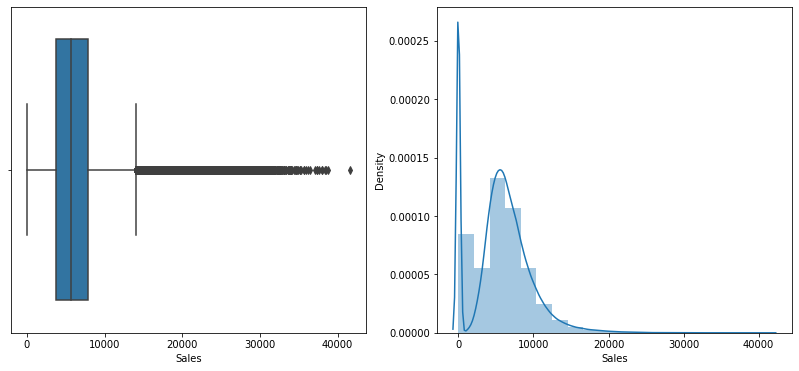

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64
The upper and lower bounds for suspected outliers are 14049.5 and -2466.5


In [20]:
# plotting the boxplot for finding the Outlier in the sales feature of the Dataset
### Sales
print('Visulaize Sales Feature')
visualize_num_feature(df.Sales)
stat_summary(df.Sales)

Visulaize Customers Feature


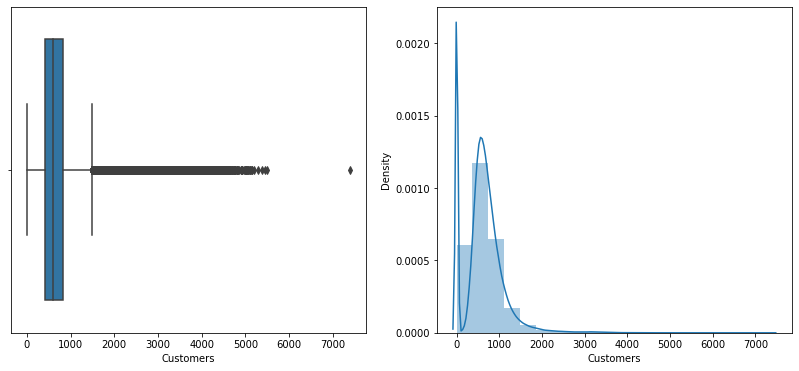

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64
The upper and lower bounds for suspected outliers are 1485.0 and -243.0


In [21]:
# plotting the boxplot and Density for finding the Outlier in the Customers feature of the Dataset
### Customers
print('Visulaize Customers Feature')
visualize_num_feature(df.Customers)
stat_summary(df.Customers)

Visulaize Open Feature


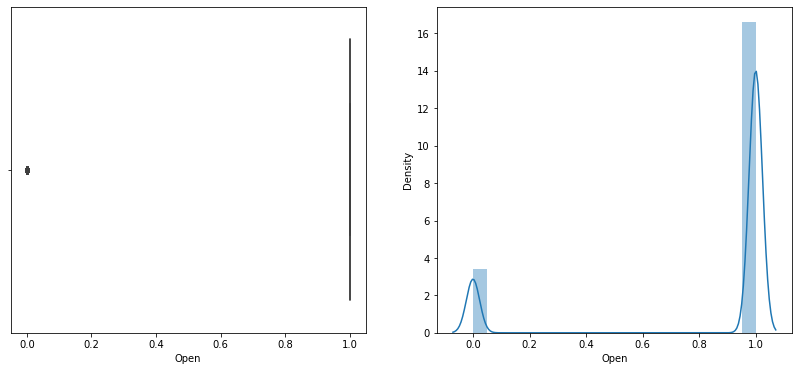

count    1.017209e+06
mean     8.301067e-01
std      3.755392e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Open, dtype: float64
The upper and lower bounds for suspected outliers are 1.0 and 1.0


In [22]:
# plotting the boxplot and Density for finding the Outlier in the Open feature of the Dataset
### Open
print('Visulaize Open Feature')
visualize_num_feature(df.Open)
stat_summary(df.Open)

Visulaize CompetitionDistance Feature


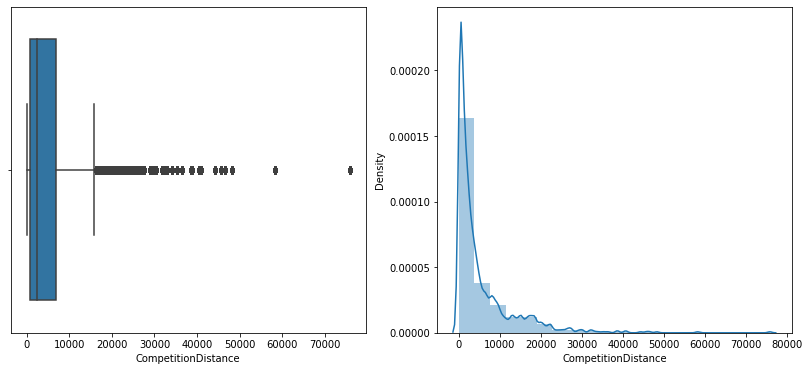

count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64
The upper and lower bounds for suspected outliers are 16160.0 and -8560.0


In [23]:
# plotting the boxplot and Density for finding the Outlier in the CompetitionDistance Dataset
### CompetitionDistance
print('Visulaize CompetitionDistance Feature')
visualize_num_feature(df.CompetitionDistance)
stat_summary(df.CompetitionDistance)

In [24]:
# Replacing The greater than 10 values with median value
df.loc[df.CompetitionDistance > 20000, 'CompetitionDistance'] = df.loc[df['CompetitionDistance']<20000,'CompetitionDistance'].median()

Visulaize CompetitionOpenSinceMonth Feature


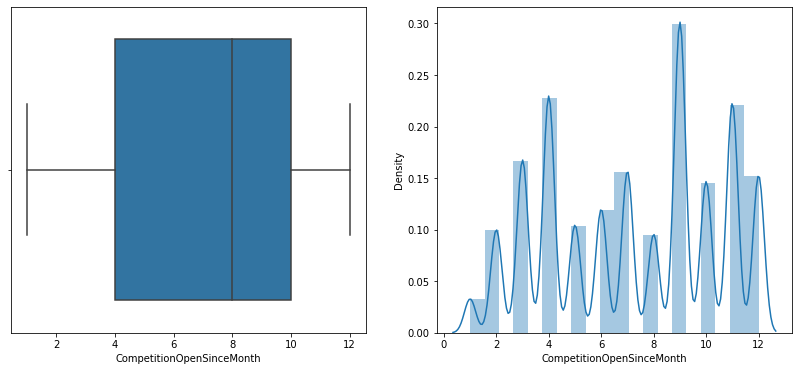

count    693861.000000
mean          7.222866
std           3.211832
min           1.000000
25%           4.000000
50%           8.000000
75%          10.000000
max          12.000000
Name: CompetitionOpenSinceMonth, dtype: float64
The upper and lower bounds for suspected outliers are 19.0 and -5.0


In [25]:
# plotting the boxplot and Density for finding the Outlier in the CompetitionDistance Dataset
### CompetitionDistance
print('Visulaize CompetitionOpenSinceMonth Feature')
visualize_num_feature(df.CompetitionOpenSinceMonth)
stat_summary(df.CompetitionOpenSinceMonth)

# Using Isolation Forest to remove outliers in the dataset


In [26]:
from sklearn.ensemble import IsolationForest

In [27]:
isolation_forest = IsolationForest(n_estimators=50, contamination=0.01)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
df['anomaly_score_univariate_sales'] = isolation_forest.decision_function(df['Sales'].values.reshape(-1, 1))
df['outlier_univariate_sales'] = isolation_forest.predict(df['Sales'].values.reshape(-1, 1))

It is clear intution that our outliers in Sales would be above 20000.

In [28]:
df[(df['outlier_univariate_sales']==-1)& (df['Sales']<20000)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,anomaly_score_univariate_sales,outlier_univariate_sales
124,125,5,2015-07-31,18227,2041,1,1,0,1,a,a,760.0,12.0,2005.0,0,NaN,NaN,NaN,-0.022700,-1
210,211,5,2015-07-31,17286,1659,1,1,0,1,a,c,350.0,11.0,2006.0,0,NaN,NaN,NaN,-0.003124,-1
319,320,5,2015-07-31,19898,2316,1,1,0,1,a,c,210.0,9.0,2012.0,0,NaN,NaN,NaN,-0.060984,-1
334,335,5,2015-07-31,17867,2592,1,1,0,1,b,a,90.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct",-0.017834,-1
466,467,5,2015-07-31,17208,1761,1,1,0,1,a,c,2170.0,4.0,2008.0,0,NaN,NaN,NaN,-0.003124,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014706,842,4,2013-01-03,18995,1107,1,0,0,1,d,c,1200.0,11.0,2007.0,0,NaN,NaN,NaN,-0.036705,-1
1014978,1114,4,2013-01-03,18463,3211,1,0,0,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,-0.028786,-1
1015230,251,3,2013-01-02,19371,2491,1,0,0,1,a,c,340.0,NaN,NaN,0,NaN,NaN,NaN,-0.049758,-1
1015767,788,3,2013-01-02,17934,1791,1,0,0,1,a,c,1530.0,3.0,2013.0,0,NaN,NaN,NaN,-0.017834,-1


In [29]:
# Total outliers 
len(df[df['outlier_univariate_sales']==-1])

10119

In [30]:
# Subsetting DF other than outliers.
df = df[df['outlier_univariate_sales']==1]

In [31]:
# Removing Isolation Forest columns
df.drop(['anomaly_score_univariate_sales','outlier_univariate_sales'],axis = 1, inplace=True)

Visulaize Sales Feature


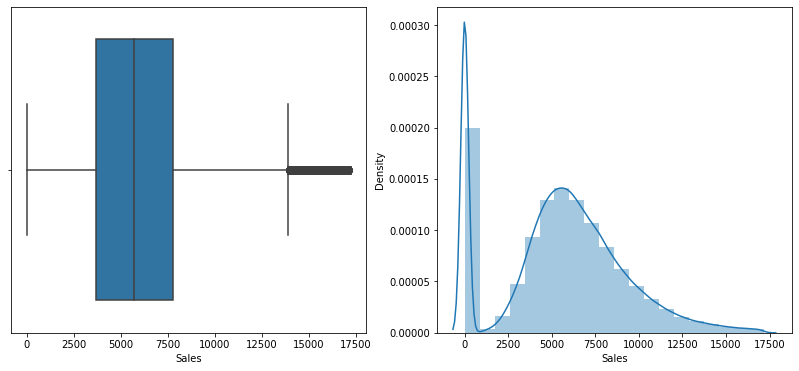

count    1.007090e+06
mean     5.628320e+03
std      3.571303e+03
min      0.000000e+00
25%      3.699000e+03
50%      5.709000e+03
75%      7.776000e+03
max      1.718200e+04
Name: Sales, dtype: float64
The upper and lower bounds for suspected outliers are 13891.5 and -2416.5


In [32]:
# sns.boxplot(df['Sales'])
# plotting the boxplot for finding the Outlier in the sales feature of the Dataset
### Sales
print('Visulaize Sales Feature')
visualize_num_feature(df.Sales)
stat_summary(df.Sales)

Visulaize Customers Feature


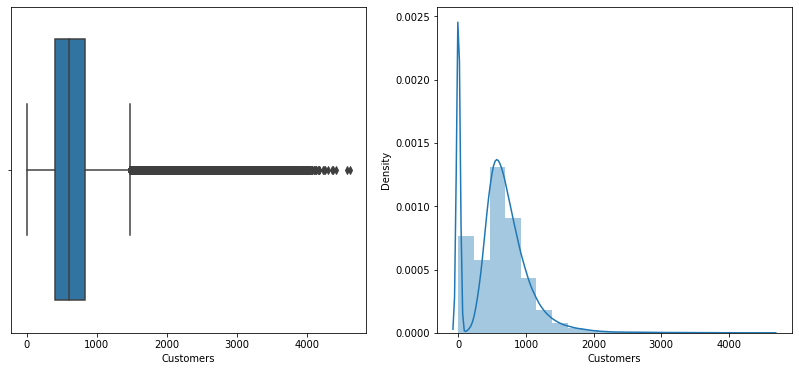

count    1.007090e+06
mean     6.151697e+02
std      4.232859e+02
min      0.000000e+00
25%      4.010000e+02
50%      6.060000e+02
75%      8.280000e+02
max      4.614000e+03
Name: Customers, dtype: float64
The upper and lower bounds for suspected outliers are 1468.5 and -239.5


In [33]:
# sns.boxplot(df['Customers'])
# plotting the boxplot and Density for finding the Outlier in the Customers feature of the Dataset
### Customers
print('Visulaize Customers Feature')
visualize_num_feature(df.Customers)
stat_summary(df.Customers)

Visulaize CompetitionDistance Feature


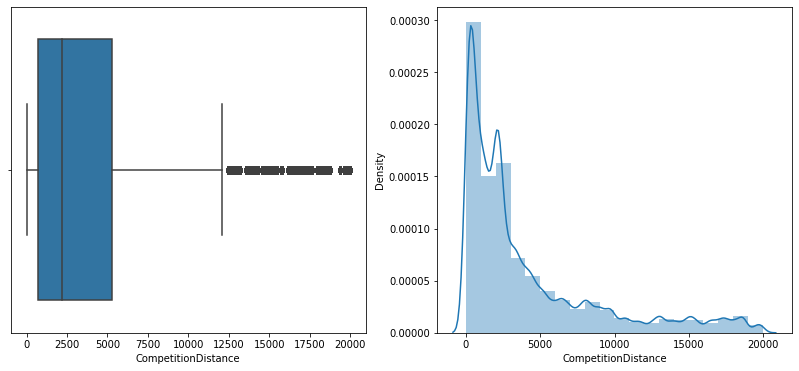

count    1.004453e+06
mean     4.031361e+03
std      4.712408e+03
min      2.000000e+01
25%      7.200000e+02
50%      2.170000e+03
75%      5.300000e+03
max      1.996000e+04
Name: CompetitionDistance, dtype: float64
The upper and lower bounds for suspected outliers are 12170.0 and -6150.0


In [34]:
# plotting the boxplot and Density for finding the Outlier in the CompetitionDistance Dataset
### CompetitionDistance
print('Visulaize CompetitionDistance Feature')
visualize_num_feature(df.CompetitionDistance)
stat_summary(df.CompetitionDistance)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007090 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1007090 non-null  int64  
 1   DayOfWeek                  1007090 non-null  int64  
 2   Date                       1007090 non-null  object 
 3   Sales                      1007090 non-null  int64  
 4   Customers                  1007090 non-null  int64  
 5   Open                       1007090 non-null  int64  
 6   Promo                      1007090 non-null  int64  
 7   StateHoliday               1007090 non-null  object 
 8   SchoolHoliday              1007090 non-null  int64  
 9   StoreType                  1007090 non-null  object 
 10  Assortment                 1007090 non-null  object 
 11  CompetitionDistance        1004453 non-null  float64
 12  CompetitionOpenSinceMonth  687225 non-null   float64
 13  CompetitionO

Date columns to Date time and extract month and year.


In [36]:
import datetime

In [37]:
# Seperating month, year and day from date.
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Day'] = pd.DatetimeIndex(df['Date']).day

In [38]:
df.drop(['Date'],axis = 1, inplace=True)

In [39]:
#StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
#Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df["StateHoliday"] = df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

In [40]:
# The data of sales histroy is between 1/01/2013 to 31/07/15, which is 2.5 years.
def plotter(StringA , StringB):
  fig, axes = plt.subplots(2,1)
  fig.set_size_inches(15, 10)
  sns.barplot(x=StringA, y=StringB, data=df ,hue="DayOfWeek", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=df ,hue="DayOfWeek", ax=axes[1])

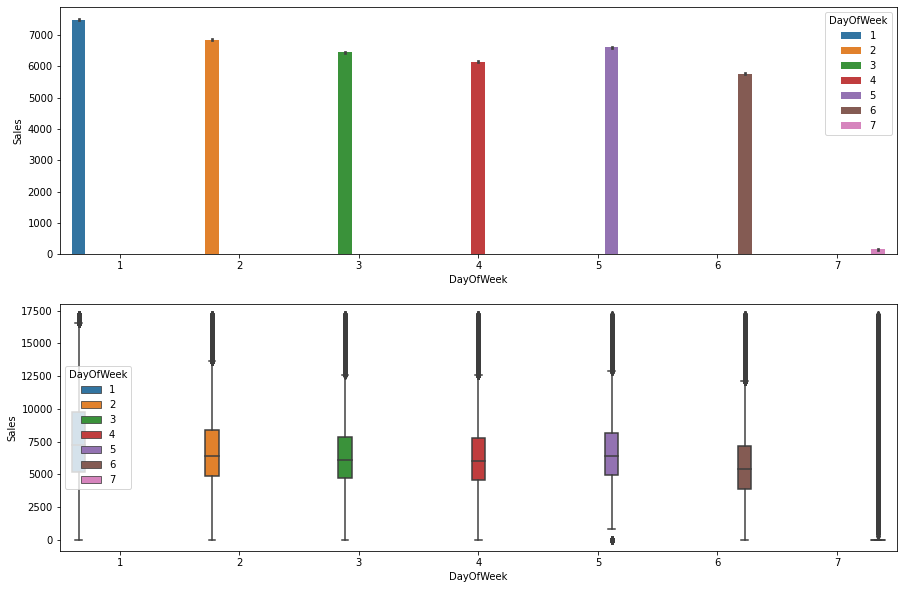

In [41]:
plotter("DayOfWeek" , "Sales")

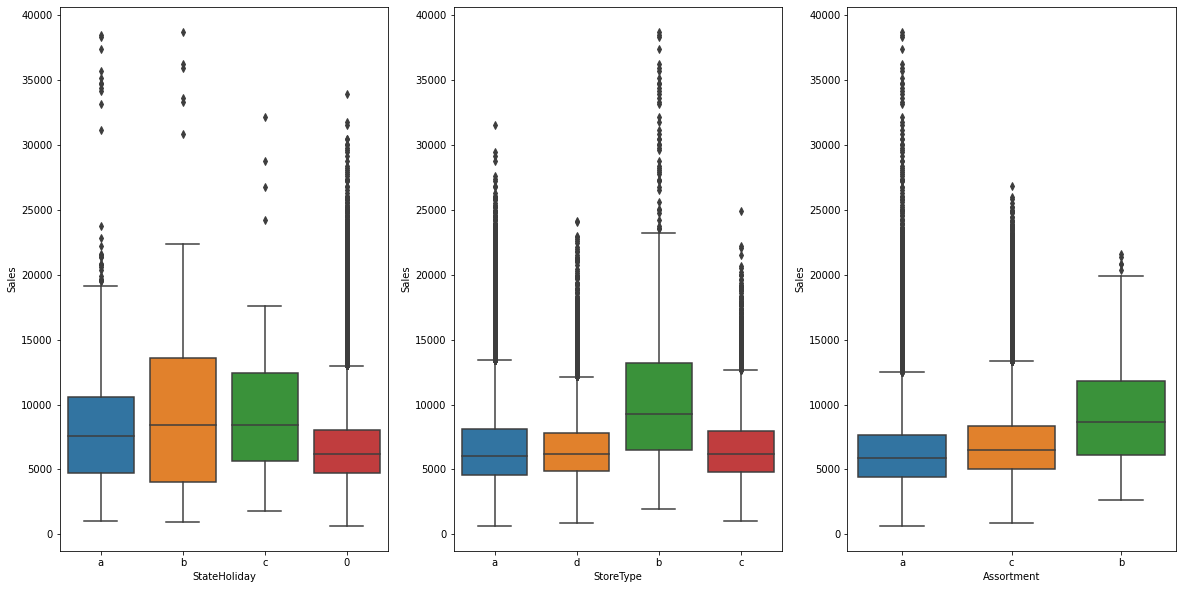

In [106]:
# plot boxplots of categorical features against target variable
plt.figure(figsize=(20,10))
aux1 = df[(df['StateHoliday'] != '0') & (df['Sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot(x='StateHoliday', y= 'Sales', data=aux1);

plt.subplot (1, 3, 2)
sns.boxplot(x='StoreType', y= 'Sales', data=aux1);

plt.subplot (1, 3, 3)
sns.boxplot(x='Assortment', y= 'Sales', data=aux1);

In [109]:
df = df[(df['Open'] != 0) & (df['Sales']> 0)]

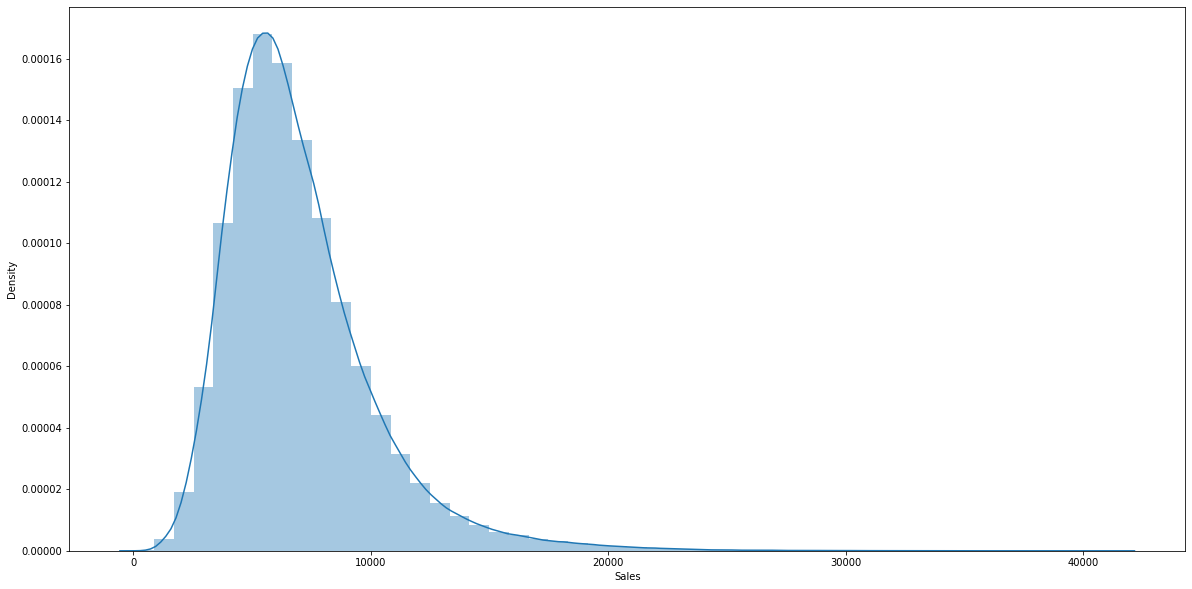

In [114]:
plt.figure(figsize=(20,10))
sns.distplot( df['Sales'] )
plt.show()

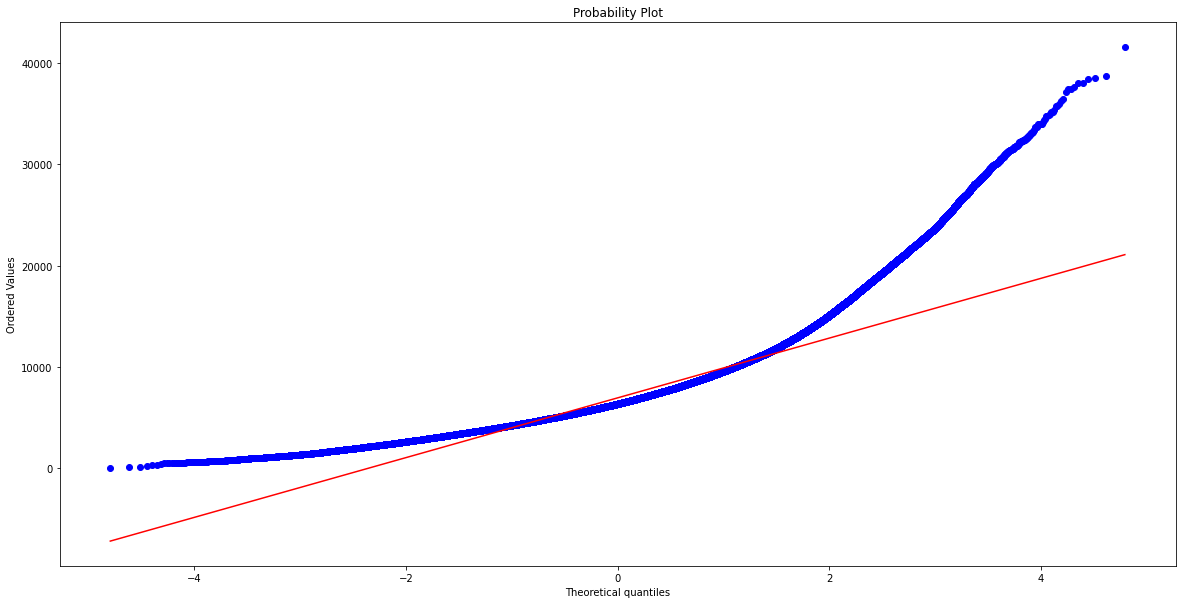

In [117]:
plt.figure(figsize=(20,10))
ss.probplot( df['Sales'], dist = 'norm', plot = pylab )
plt.show()

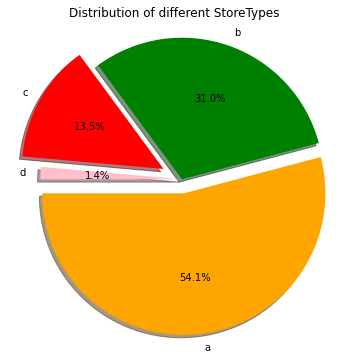

In [42]:
labels = 'a' , 'b' , 'c' , 'd'
sizes = df.StoreType.value_counts()
colors = ['orange', 'green' , 'red' , 'pink']
explode = (0.1, 0.0 , 0.15 , 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [89]:
def plotmaster(StringA , StringB):
  fig, axes = plt.subplots(3,1)
  fig.set_size_inches(12, 15)
  sns.barplot(x=StringA, y=StringB, data=df_store ,hue="Assortment", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=df_store ,hue="Assortment", ax=axes[1])

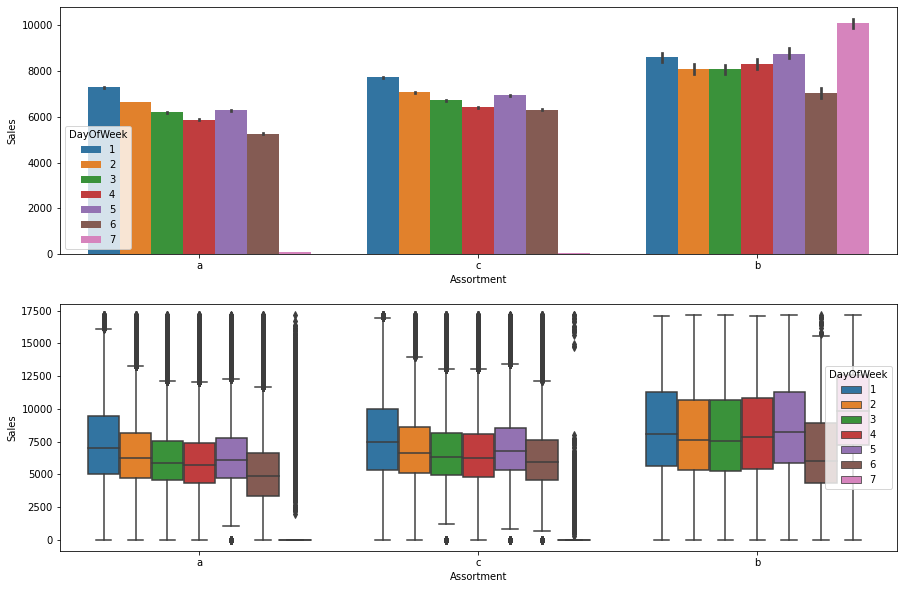

In [44]:
plotter("Assortment" , "Sales")

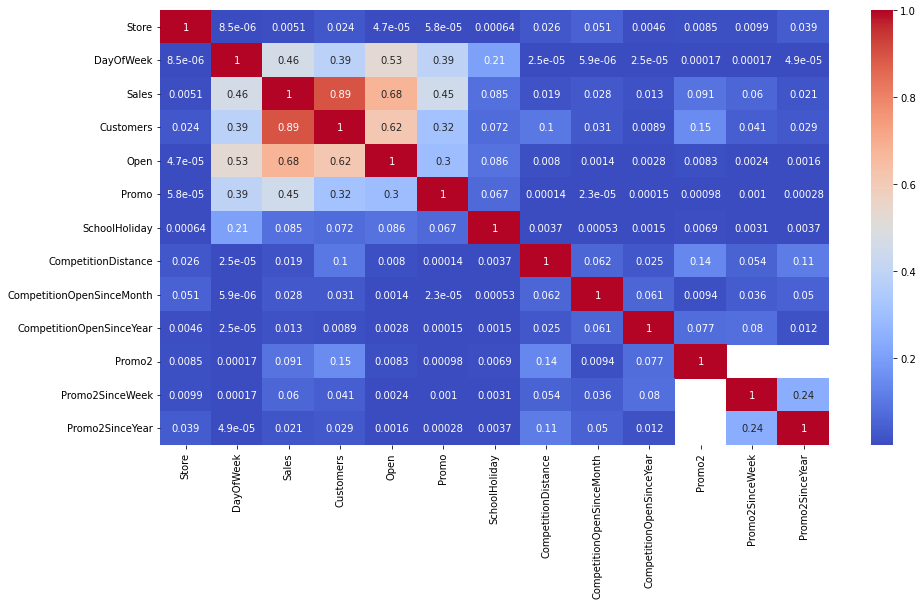

In [99]:
# Plotting Heatmap for the correlation of independent variables with dependent variable 
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(15,8))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [45]:
df['Sales'] = np.sqrt(df['Sales'])
df['Customers'] = np.sqrt(df['Customers'])
df['CompetitionDistance'] = np.sqrt(df['CompetitionDistance'])